In [1]:
import os
import pylab
import numpy as np
import pandas as pd
from matplotlib import rc
from matplotlib import pyplot as plt
import pickle

from liquidity.util.utils import get_agg_features
from liquidity.response_functions.fitting import compute_shape_parameters, renormalise

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Window/bin size for computing imbalances
T = 1000

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Fitting Scaling Form

    - Find Alpha and Beta

Approach I: fit scaling form on all data to find exponents and then use them for renormalisation.

In [5]:
MO_LAG_INTERVALS = list(range(1, T))

### Get results for other stocks

In [89]:
popt_ebay, pcov_ebay, fit_func_ebay, data_norm_ebay = compute_shape_parameters(ebay_raw_df, MO_LAG_INTERVALS)
# popt_msft, pcov_msft, fit_func_msft, data_norm_msft = compute_shape_parameters(msft_raw_df, MO_LAG_INTERVALS)
# popt_appl, pcov_appl, fit_func_appl, data_norm_appl = compute_shape_parameters(appl_raw_df, MO_LAG_INTERVALS)
# popt_nflx, pcov_nflx, fit_func_nflx, data_norm_nflx = compute_shape_parameters(nflx_raw_df, MO_LAG_INTERVALS)
# popt_amzn, pcov_amzn, fit_func_amzn, data_norm_amzn = compute_shape_parameters(amzn_raw_df, MO_LAG_INTERVALS)

In [90]:
# result_all = {
#     'TSLA': (popt_tsla, pcov_tsla, fit_func, data_norm),
#     'EBAY': (popt_ebay, pcov_ebay, fit_func_ebay, data_norm_ebay),
#     'MSFT': (popt_msft, pcov_msft, fit_func_msft, data_norm_msft),
#     'APPL': (popt_appl, pcov_appl, fit_func_appl, data_norm_appl),
#     'NFLX': (popt_nflx, pcov_nflx, fit_func_nflx, data_norm_nflx),
#     'AMZN': (popt_amzn, pcov_amzn, fit_func_amzn, data_norm_amzn)
# }

In [6]:
import pickle
# pickle.dump(result_all, open('../../data/generated/shape_parameters_mo.pkl', 'wb'))
shape_params_dict = pickle.load(open('../../data/generated/shape_parameters_mo.pkl', 'rb'))
shape_params_dict.keys()

dict_keys(['TSLA', 'EBAY', 'MSFT', 'APPL', 'NFLX', 'AMZN'])

In [7]:
appl_shape_params = shape_params_dict['APPL']

In [8]:
popt_appl, pcov_appl, fit_func_appl, data_norm_appl = appl_shape_params

In [9]:
chi, kappa, alpha, beta, gamma = popt_appl

In [10]:
chi

0.5277979122995787

In [11]:
kappa

0.8282064394561939

In [12]:
alpha

0.521073801226079

In [13]:
beta

868.318406822373

## 1.1. Before Collapse

In [ ]:
"""
* for a given list of lags fit scaling function
* use LS for fitting --> test

* integrate goodness of fit for LS --> test
* integrate goodness of fit for MLE --> test

* plot data with fits for each N

"""

In [81]:
from liquidity.response_functions.fitting import least_squares_fit, scaling_function,scaling_form, fit_scaling_form, fit_scaling_function

from liquidity.util.utils import bin_data_into_quantiles

In [109]:
FITTING_LAGS = [10, 20, 50, 100]

In [110]:
# agg_features_df = pickle.load(open('../../data/generated/appl_aggregate_features_mo_df.pkl', 'rb'))

In [111]:
agg_features_df = get_agg_features(appl_raw_df, FITTING_LAGS,remove_outliers=True)

In [118]:
from scipy.optimize import curve_fit

fit_result_dict = {}
for lag in FITTING_LAGS:
    data = agg_features_df[agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)

    fit_result_dict[lag] = fit_scaling_form(data_binned)
    # fit_result_dict[lag] = fit_scaling_function(data_binned)


In [114]:
fit_result_dict[100]

(array([2.16140815e+00, 2.66248012e-06, 4.58760239e-01, 5.59434290e+01,
        1.12659205e+00]),
 23.878360544875022,
 <function liquidity.response_functions.fitting.scaling_form(orderflow_imbalance, chi, kappa, alpha, beta, gamma)>)

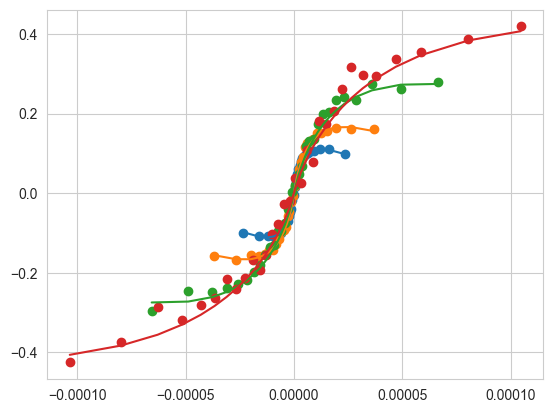

In [130]:
for lag, fit_result in fit_result_dict.items():
    # plt.figure(figsize=(4, 4))
    param = fit_result[0]
    data = agg_features_df[agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    q = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_form(q, *param)
    plt.scatter(xs, ys)
    plt.plot(q[0], y_hat)

In [148]:
FITTING_LAGS = (10, 20, 50, 100)

In [149]:

fit_result_dict = {}
for lag in FITTING_LAGS:
    data = agg_features_df[agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)

    # fit_result_dict[lag] = fit_scaling_form(data_binned)
    fit_result_dict[lag] = fit_scaling_function(data_binned)


In [150]:
fit_result_dict[100]

(array([1.19143953e-05, 8.39196637e-11]),
 99.98730809184896,
 <function liquidity.response_functions.fitting.scaling_function(x: float, alpha: float, beta: float) -> float>)

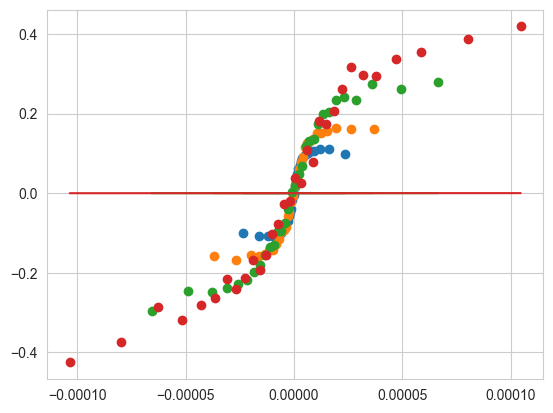

In [143]:
for lag, fit_result in fit_result_dict.items():
    # plt.figure(figsize=(4, 4))
    param = fit_result[0]
    data = agg_features_df[agg_features_df['T']==lag][["vol_imbalance", "T", "R"]]
    data_binned = bin_data_into_quantiles(data, q=31)
    xs = data_binned["vol_imbalance"].values
    ys = data_binned["R"].values
    # q = np.transpose(data_binned.iloc[:, :2].to_numpy())
    y_hat = scaling_function(xs, *param)
    plt.scatter(xs, ys)
    plt.plot(xs, y_hat)

## 1.2. After Collapse

In [ ]:
"""
Lage beta:

- fix 1: restraint volume imbalance scope when fitting (requires re-running fit of scaling form for each N each stock

- temp fix 2: remove outliers in the series of RN and QN

"""

## 2. Fitting Rescaled Form

    - Find RN, QN, given Alpha, Beta

Approach II: produce series of RN and QN by fitting scaling funtion for different N, then use powerlaw library to fit power law and determine scale factors; finally, fit known scaling form to find exponents and then use them for renormalisation.

In [13]:
LAGS = list(range(1, 1001))

In [ ]:
# # Aggregate orderflow
# tsla_imbalance = get_agg_features(tsla_raw_df, LAGS, remove_outliers=False)
# pickle.dump(tsla_imbalance, open('../../data/generated/tsla_aggregate_features_mo_df.pkl', 'wb'))

In [34]:
# msft_imbalance = get_agg_features(msft_raw_df, LAGS, remove_outliers=False)
# pickle.dump(msft_imbalance, open('../../data/generated/msft_aggregate_features_mo_df.pkl', 'wb'))

In [35]:
# amzn_imbalance= get_agg_features(amzn_raw_df, LAGS, remove_outliers=False)
# pickle.dump(amzn_imbalance, open('../../data/generated/amzn_aggregate_features_mo_df.pkl', 'wb'))

In [36]:
# nflx_imbalance = get_agg_features(nflx_raw_df, LAGS,remove_outliers=False)
# pickle.dump(nflx_imbalance, open('../../data/generated/nflx_aggregate_features_mo_df.pkl', 'wb'))

In [37]:
# ebay_imbalance = get_agg_features(ebay_raw_df, LAGS, remove_outliers=False)
# pickle.dump(ebay_imbalance, open('../../data/generated/ebay_aggregate_features_mo_df.pkl', 'wb'))

In [38]:
# appl_imbalance = get_agg_features(appl_raw_df, LAGS,remove_outliers=False)
# pickle.dump(appl_imbalance, open('../../data/generated/appl_aggregate_features_mo_df.pkl', 'wb'))

### Load pre-computed data

In [27]:
appl_features_df = pickle.load(open('../../data/generated/appl_aggregate_features_mo_df.pkl', 'rb'))

In [15]:
from IPython.display import display
display(appl_features_df.head())

,event_timestamp,midprice,vol_imbalance,sign_imbalance,sign,daily_R1,daily_vol,daily_num,R,T
0,2017-01-03 10:30:19.351489154,219.325,2.934072e-08,0.000305,1,0.021159,277786,3279,0.000,1
1,2017-01-03 10:30:19.351537884,219.325,4.401108e-07,0.000305,1,0.021159,277786,3279,0.005,1
2,2017-01-03 10:30:19.351549791,219.330,2.347257e-06,0.000305,1,0.021159,277786,3279,0.005,1
3,2017-01-03 10:30:19.351601187,219.335,2.347257e-06,0.000305,1,0.021159,277786,3279,0.000,1
4,2017-01-03 10:30:19.351702603,219.335,1.173629e-06,0.000305,1,0.021159,277786,3279,0.050,1


### Generate series of RN and QN by fitting scaling form with known parameters of alpha and beta

In [25]:
from liquidity.response_functions.fitting import compute_RN_QN

In [28]:
# fit powerlaw on series of RN and QN ranges
RN_df, QN_df, RN_fit_object, QN_fit_object = compute_RN_QN(appl_features_df, alpha, beta)

/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/fitting.py:38: RuntimeWarning: overflow encountered in power
  return x / (1 + abs(x) ** alpha) ** (beta / alpha)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/fitting.py:38: RuntimeWarning: overflow encountered in power
  return x / (1 + abs(x) ** alpha) ** (beta / alpha)


[]

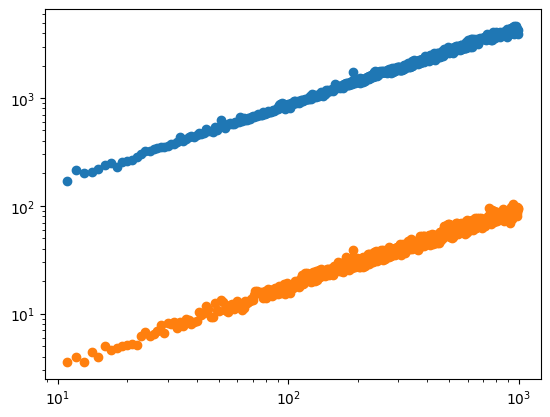

In [29]:
plt.scatter(RN_df['x_values'],RN_df['y_values'])
plt.scatter(QN_df['x_values'],QN_df['y_values'])
plt.loglog()

In [30]:
RN_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 21.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 34.243376287073396
alpha = 0.7046514589153091

Goodness of fit to data;
D = 0.02613240418118467
bic = 5273.130510313039
mape = 3.0032334784226298
Adjusted R-squared = 0.9915444240723101




In [31]:
QN_fit_object.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 21.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.7138946658340644
alpha = 0.7057269991562459

Goodness of fit to data;
D = 0.020905923344947737
bic = 1614.5259857378246
mape = 6.860499484714514
Adjusted R-squared = 0.968111850380766




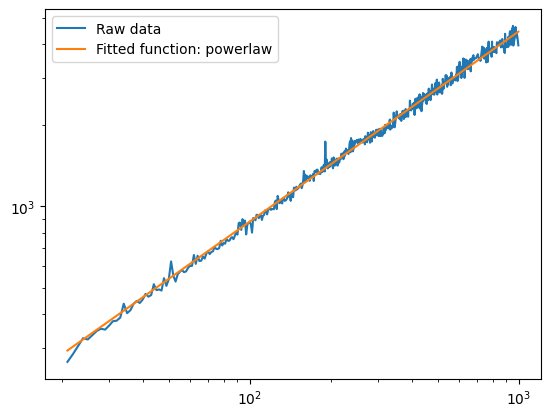

In [32]:
RN_fit_object.powerlaw.plot_fit()

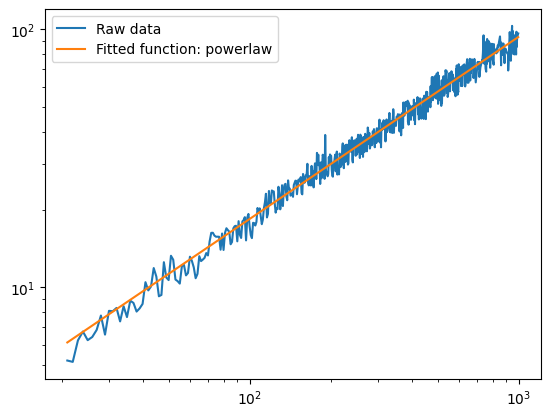

In [33]:
QN_fit_object.powerlaw.plot_fit()